In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# change your work directory accordingly
%pwd #~/Documents/WQU/assignment_01/

'C:\\Users\\neelkanth mehta\\Documents\\WQU\\machine_learning_for_finance\\assignment_01\\financial-data-structures'

#### Creating time, tick, volume and dollar bars from raw tick data.
<br> The data has been cloned from the provided repo: https://github.com/Jackal08/financial-data-structures.git
* What is referred to as observation in standard machine learning parlance, finance practitioners refer to as 'bars'. We shall use both, interchangeably.
* The manner in which bars are organized and stored could broadly be distingueshed into standard and alternate (more advanced) methods.
* Standard approach is to aggregate security price dataset per equal time intervals, for e.g., by second, by minute etc. Author Lopez de Prado, M. argue that these should be avoided for two reasons:
    * markets do not process info at constant level. The hr. following the opening bel is much more active than the hr. in the noon. This implies that time bars over sample during slack hrs. and under sample during more active hrs. <font size=1.7>(Easley, Lopez de Prado, and O’Hara [2011])</font>
    * often time sampled often exhibit poor statistical properties *viz*., serial correlation, heteroskedasticity, non-normality etc. <font size=1.7>(Easley, Lopez de Prado, and O’Hara [2012])</font>
* The alternative approach include aggregating bars based on ticks, volume or dollar/ any currency.
    * *tick* --> the sample variables (timestamp, VWAP, ohlc) will be extracted each time a pre-defined number of transactions takes, for e.g., 1K ticks/ orders. 
        - The argued advantage is that the observations are aggregated based on information arrival. 
        - Price changes over a fixed number of transactions exhibit desirable statistical properties <font size=1.7> Mandelbrot and Tylor (1967)</font>.<br> Several studies have confirmed that returns thus acheived are closer to normal and being IID <font size=1.7> Ane and Geman (2000)</font>
    * *volume* --> one problem with tick bars is the order fragmentation introduces some arbitrariness in the number of ticks. Volume bars circumvent that problem by sampling every time a pre-defined amount of units have been exchanged; for e.g., every 1K units exchanged, regardless the no. of ticks/ orders involved.
        - The statistical properties of the volume aggregated bars are even better than tick, i.e., closer to IID Gaussian, tham sampling by tick bars.
        - Several market microstructure theories study an interaction between prices and volume.
    * *Dollar* --> obserations are aggregated based on, say every $1K worth of orders.
        - Are not susceptible to corporate actions like stock split or M&A etc.
        - No. of shares traded is function of actual value exchanged, rather than tick or volume, particularly when the analysis involves significant price fluctuation.
    * Other approaches not discussed here include information-driven bars wherein observations are aggregated based on new information arriving to the market.

In [2]:
# Fetching data
tick_ = pd.read_csv('tick_bars.csv').set_index('date')
vol_  = pd.read_csv('volume_bars.csv').set_index('date')
time_ = pd.read_csv('time_bars.csv').set_index('date')
dollar= pd.read_csv('dollar_bars.csv').set_index('date')

In [3]:
# Setting Datatime index
tick_.index  = pd.to_datetime(tick_.index)
vol_.index   = pd.to_datetime(vol_.index)
time_.index  = pd.to_datetime(time_.index)
dollar.index = pd.to_datetime(dollar.index)

          tick      vol     time        $
count  1091.00  1001.00    39.00  1024.00
mean   1677.67  1677.97  1676.31  1678.37
std      25.98    25.88    25.14    25.89
min    1631.25  1631.75  1634.00  1631.50
25%    1654.00  1654.00  1654.12  1654.25
50%    1680.50  1680.50  1680.00  1680.75
75%    1697.12  1697.50  1694.88  1697.75
max    1726.50  1726.25  1721.75  1725.50


(array([1, 2, 3, 4]), <a list of 4 Text xticklabel objects>)

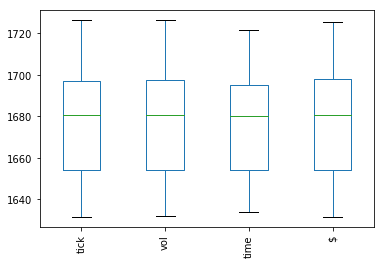

In [25]:
df = pd.concat((tick_['close'], vol_['close'], time_['close'], dollar['close']), axis=1)
df.columns = ['tick', 'vol', 'time', '$']
print(f"{round(df.describe(),2)}")

df.plot.box()
plt.xticks(rotation=90)

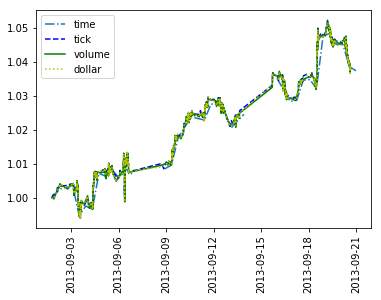

In [30]:
plt.plot(time_['close']/ time_['close'][0], '-.', label='time')
plt.plot(tick_['close']/ tick_['close'][0], 'b--', label='tick')
plt.plot(vol_['close']/ vol_['close'][0], 'g-',label='volume')
plt.plot(dollar['close']/ dollar['close'][0], 'y:',label='dollar')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [53]:
X = pd.date_range(start=time_.index[0], end=time_.index[-1], freq='H')
y = time_.groupby(time_.index).count()

#### What 'bar' type produces the most stable weekly count?
<br> Stable weekly count are referred for least variation in counts over the weeks.

In [5]:
tick_weekly = tick_['close'].resample('W')
vol__weekly =  vol_['close'].resample('W')
time_weekly = time_['close'].resample('W')
dollaweekly =dollar['close'].resample('W')

In [6]:
count_df = pd.concat((tick_weekly.count(), vol__weekly.count(), time_weekly.count(), dollaweekly.count()), axis=1)
count_df.columns = ['tick', 'vol', 'time','dollar']

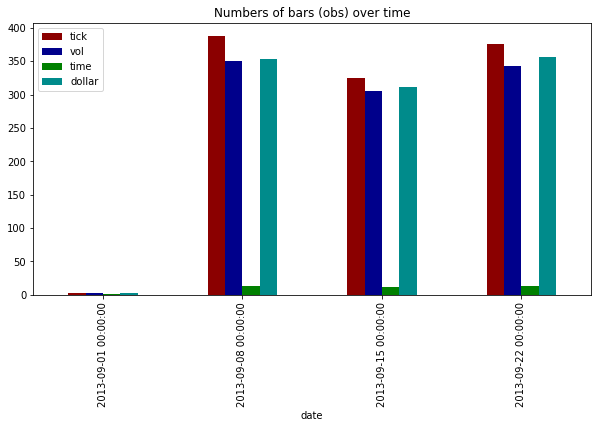

In [55]:
count_df.plot(kind='bar', figsize=[10, 5], color=('darkred', 'darkblue', 'green', 'darkcyan'))
plt.title('Numbers of bars (obs) over time')
plt.show()

The sample size of the data is small enough to enable us draw conclusion. But the chart above shows how how alternate approach dwarf the standard time approach.

#### Checking for the presence of autocorrelation among the bar types:
<br> As stated above the alternate data structures offer better statistical properties compared to standard time aggregated data.<br> In the following two sections, we shall ascertain to what extend autocorrelation is present in each structure, and later, whether the sample is Gaussian IID.

In [59]:
from statsmodels.graphics.tsaplots import plot_acf

In [60]:
time_returns = np.log(time_['close']).diff().dropna()
tick_returns = np.log(tick_['close']).diff().dropna()
vol__returns = np.log(vol_['close']).diff().dropna()
dollarweekly = np.log(dollar['close']).diff().dropna()

plot_acf(time_returns, lags=10)  # Testing Autocorrelation in time bars
plt.title('Time Bars AutoCorrelation')
plt.show()

plot_acf(tick_returns, lags=10)  # Testing Autocorrelation in tick bars
plt.title('Tick Bars Autocorrelation')
plt.show()

plot_acf(vol__returns, lags=10)  # Testing Autocorrelation in volume bars
plt.title('Volume Bars Autocorrelation')
plt.show()

plot_acf(dollarweekly, lags=10)  # Testing Autocorrelation in dollar bars
plt.title('Dollar Bars Autocorrelation')
plt.show()

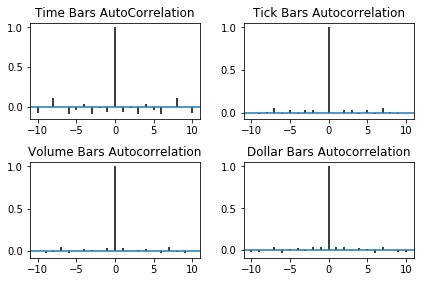

In [67]:
plt.subplot(2,2,1)
plt.acorr(time_returns)  # Testing Autocorrelation in time bars
plt.title('Time Bars AutoCorrelation')
# plt.show()

plt.subplot(2,2,2)
plt.acorr(tick_returns)  # Testing Autocorrelation in tick bars
plt.title('Tick Bars Autocorrelation')
# plt.show()

plt.subplot(2,2,3)
plt.acorr(vol__returns)  # Testing Autocorrelation in volume bars
plt.title('Volume Bars Autocorrelation')
# plt.show()

plt.subplot(2,2,4)
plt.acorr(dollarweekly)  # Testing Autocorrelation in dollar bars
plt.title('Dollar Bars Autocorrelation')

plt.tight_layout(True)
plt.show()

#### Test of normality
<br> Most of the statistical mehtods, or machine learning algorithms assume the data is normally and IID...

In [13]:
from scipy.stats import jarque_bera

In [14]:
cols = [tick_returns, vol__returns, time_returns, dollarweekly]
cols_dict = dict(zip(count_df,cols))

In [15]:
for key, value in cols_dict.items():
    print(f"{key} score: {round(jarque_bera(value)[0],3)}; p-val: {round(jarque_bera(value)[1],3)}")

tick score: 4521.614; p-val: 0.0
vol score: 4911.461; p-val: 0.0
time score: 11.518; p-val: 0.003
dollar score: 11916.74; p-val: 0.0


Again, the time aggregated sample has got slightly higher p-value. At $\alpha=1$, time sample could be rejected.